In [1]:
import numpy as np
from pprint import pprint
import os
from pathlib import Path

dir_path = str(Path(os.getcwd()).parent.absolute())

from dwsimopt.solve_sim_opt import OptimiSim

In [2]:
# Loading DWSIM simulation into Python (Simulation object)
sim_smr = OptimiSim(path2sim= os.path.join(dir_path, "examples\\SMR_LNG\\SMR.dwxmz"), 
                    path2dwsim = "C:\\Users\\lfsfr\\AppData\\Local\\DWSIM731\\",
                    savepath = os.path.join(dir_path, "examples\\SMR_LNG\\SMR2.dwxmz"),
                    init_dwsim=True)

added refs
Simulation was loaded successfully


In [3]:
from dwsimopt.py2dwsim import * 

# Assign DoF:
create_pddx( ["MR-1", "CompoundMassFlow", "Nitrogen", "kg/s"],    sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Methane", "kg/s"],     sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Ethane", "kg/s"],      sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Propane", "kg/s"],     sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Isopentane", "Pa"],    sim_smr, element="dof" )
create_pddx( ["VALV-01", "OutletPressure", "Mixture", "Pa"],      sim_smr, element="dof" )
create_pddx( ["COMP-4", "OutletPressure", "Mixture", "Pa"],       sim_smr, element="dof" )
create_pddx( ["COOL-08", "OutletTemperature", "Mixture", "K"],    sim_smr, element="dof" )

# Assign F
create_pddx( ["Sum_W", "EnergyFlow", "Mixture", "kW"], sim_smr, element="fobj" )

# adding constraints (g_i <= 0):
g1 = create_pddx( ["MITA1-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint", assign=False )
assign_pddx( lambda: 3-g1[0]() , ["MITA1-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint" )
g2 = create_pddx( ["MITA2-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint", assign=False )
assign_pddx( lambda: 3-g2[0]() , ["MITA2-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint" )
# assign_pddx( lambda: 3 - min(g2[0](),g1[0]()), ["MITA_Overall", "OutputVariable", 'mita', "°C"], sim_smr, element="constraint" )


pprint(vars(sim_smr))

Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001D81551DCA0> a dof pddx function for CompoundMassFlow of Nitrogen (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001D81551DCA0> a dof pddx function for CompoundMassFlow of Methane (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001D81551DCA0> a dof pddx function for CompoundMassFlow of Ethane (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001D81551DCA0> a dof pddx function for CompoundMassFlow of Propane (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001D81551DCA0> a dof pddx function for CompoundMassFlow of Isopentane (if applicable) from MR-1 in Pa (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim obj

In [4]:
# Initial simulation optimization setup
# Initial guess of optimization
x0 = np.array( [0.25/3600, 0.70/3600, 1.0/3600, 1.10/3600, 1.80/3600, 2.50e5, 50.0e5, -60+273.15] )

# Testing for simulation at x0
sim_smr.calculate_optProblem(1.0*x0)
print(sim_smr.x_val,
      sim_smr.f_val,
      sim_smr.g_val)

# Test saving simulation at x0 in 'savepath'
sim_smr.interface.SaveFlowsheet(sim_smr.flowsheet,sim_smr.savepath,True)

# Inspecting simulation object
pprint(vars(sim_smr))

opt_functions calculation at x = [6.94444444e-05 1.94444444e-04 2.77777778e-04 3.05555556e-04
 5.00000000e-04 2.50000000e+05 5.00000000e+06 2.13150000e+02]
               Simulation converged in 3 iterations
f = [0.38910439], g = [-1.78887878 -3.47846713] at x = [6.94444444e-05 1.94444444e-04 2.77777778e-04 3.05555556e-04
 5.00000000e-04 2.50000000e+05 5.00000000e+06 2.13150000e+02]
[6.94444444e-05 1.94444444e-04 2.77777778e-04 3.05555556e-04
 5.00000000e-04 2.50000000e+05 5.00000000e+06 2.13150000e+02] [0.38910439] [-1.78887878 -3.47846713]
{'dof': array([[<function _toDwsim.<locals>.<lambda> at 0x000001D81560AAF0>,
        'MR-1', 'CompoundMassFlow', 'Nitrogen', 'kg/s'],
       [<function _toDwsim.<locals>.<lambda> at 0x000001D81560AC10>,
        'MR-1', 'CompoundMassFlow', 'Methane', 'kg/s'],
       [<function _toDwsim.<locals>.<lambda> at 0x000001D82C8EE280>,
        'MR-1', 'CompoundMassFlow', 'Ethane', 'kg/s'],
       [<function _toDwsim.<locals>.<lambda> at 0x000001D81560ACA0>,


In [5]:
# Setup for optimization
# decision variables bounds
bounds = np.array( [0.75*np.asarray(x0), 1.25*np.asarray(x0)] )   # 50 % around base case
bounds[0][-1] = 153     # precool temperature low limit manually
bounds[1][-1] = 253     # precool temperature upper limit manually

xlo = bounds[0]
xup = bounds[1]

Starting global optimization
Iter: 0, Best fit: [30870.98664106] at [6.47504375e-05 1.67081287e-04 2.08333333e-04 3.81944444e-04
 3.95330665e-04 2.41825790e+05 3.75000000e+06 2.53000000e+02]
Iter: 1, Best fit: [30870.98664106] at [6.47504375e-05 1.67081287e-04 2.08333333e-04 3.81944444e-04
 3.95330665e-04 2.41825790e+05 3.75000000e+06 2.53000000e+02]
Iter: 2, Best fit: [30870.98664106] at [6.47504375e-05 1.67081287e-04 2.08333333e-04 3.81944444e-04
 3.95330665e-04 2.41825790e+05 3.75000000e+06 2.53000000e+02]
PSO finished with x* = [6.47504375e-05 1.67081287e-04 2.08333333e-04 3.81944444e-04
 3.95330665e-04 2.41825790e+05 3.75000000e+06 2.53000000e+02]
fobj = self.f[0]()
g_0 = 12.571324994545648
g_1 = 18.299359027951596


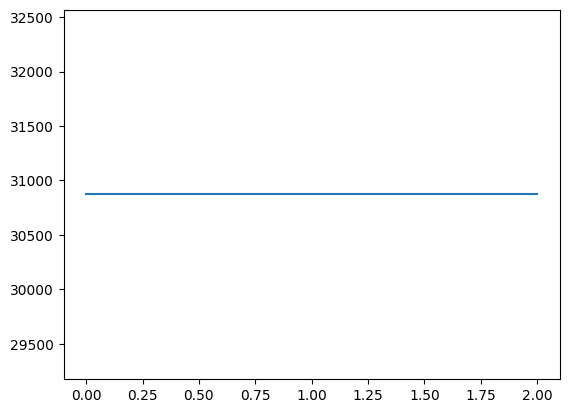

In [6]:
# Global optimization with PSO
sim_smr.verbose = False
sim_smr.PSO(x0, xlo, xup, pop=1, max_ite=3)


Starting global optimization
GA finished with x* = [5.56846597e-05 1.73869067e-04 2.86360799e-04 2.40138007e-04
 5.50946276e-04 2.29106613e+05 4.35358211e+06 2.28890588e+02]
fobj = self.f[0]()
g_0 = -0.961705327255487
g_1 = -3.068492499310267


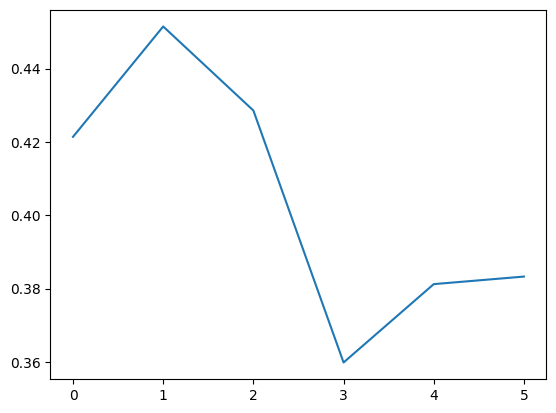

In [7]:
# Global optimization with GA
sim_smr.verbose = False
sim_smr.GA(x0, xlo, xup, pop=2, max_ite=3, prob_mut=0.2)